<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/regression_and_characterization/DTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dynamic Time Warping (DTW)

## Introduction
**Dynamic Time Warping (DTW)** is a way to compare two -usually temporal- sequences that do not sync up perfectly. It is a method to calculate the optimal matching between two sequences. DTW is useful in many domains such as speech recognition, data mining, financial markets, etc. It’s commonly used in data mining to measure the distance between two time-series.

Let’s assume we have two sequences like the following:

𝑋=𝑥[1], 𝑥[2], …, x[i], …, x[n]

Y=y[1], y[2], …, y[j], …, y[m]

The sequences 𝑋 and 𝑌 can be arranged to form an 𝑛-by-𝑚 grid, where each point (𝑖, j) is the alignment between 𝑥[𝑖] and 𝑦[𝑗].

By some constraints to avoid combinatorically explosive, An acceptable warping path has combinations of chess king moves that are:
- Horizontal moves: (𝑖, 𝑗) → (𝑖, 𝑗+1)
- Vertical moves: (𝑖, 𝑗) → (𝑖+1, 𝑗)
- Diagonal moves: (𝑖, 𝑗) → (𝑖+1, 𝑗+1)


In [ ]:
import pandas as pd
import numpy as np
# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn
# Configuring Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
savefig_options = dict(format="png", dpi=100, bbox_inches="tight")
# Computation packages
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def compute_euclidean_distance_matrix(x, y) -> np.array:
    """Calculate distance matrix
    This method calcualtes the pairwise Euclidean distance between two sequences.
    The sequences can have different lengths.
    """
    dist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            dist[i,j] = (x[j]-y[i])**2
    return dist

def compute_accumulated_cost_matrix(x, y) -> np.array:
    """Compute accumulated cost matrix for warp path using Euclidean distance
    """
    distances = compute_euclidean_distance_matrix(x, y)

    # Initialization
    cost = np.zeros((len(y), len(x)))
    cost[0,0] = distances[0,0]
    
    for i in range(1, len(y)):
        cost[i, 0] = distances[i, 0] + cost[i-1, 0]  
        
    for j in range(1, len(x)):
        cost[0, j] = distances[0, j] + cost[0, j-1]  

    # Accumulated warp path cost
    for i in range(1, len(y)):
        for j in range(1, len(x)):
            cost[i, j] = min(
                cost[i-1, j],    # insertion
                cost[i, j-1],    # deletion
                cost[i-1, j-1]   # match
            ) + distances[i, j] 
            
    return cost
  


The DTW distance: 6.0
The DTW path: [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4), (4, 5), (4, 6)]


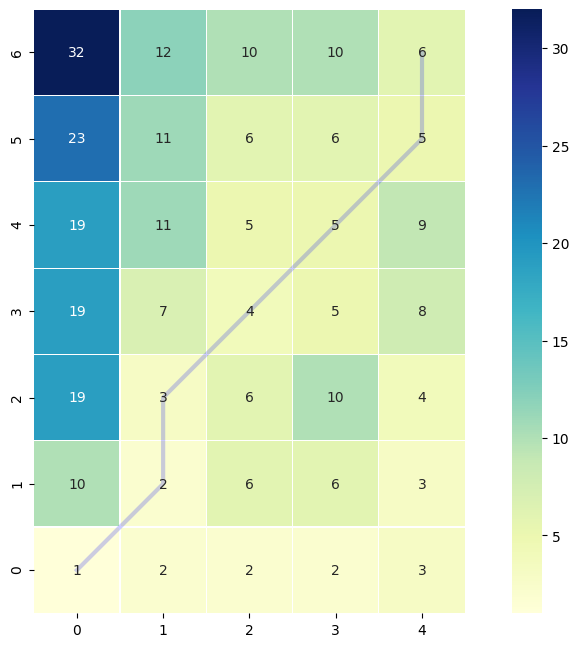

In [ ]:
# Example1:
# Create two sequences
x = [3, 1, 2, 2, 1]
y = [2, 0, 0, 3, 3, 1, 0]

dtw_distance, warp_path = fastdtw(x, y, dist=euclidean)
cost_matrix = compute_accumulated_cost_matrix(x, y)
fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()

# Get the warp path in x and y directions
path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

# Align the path from the center of each cell
path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

# Print the distance and the path
print("The DTW distance:", dtw_distance)
print("The DTW path:", warp_path)

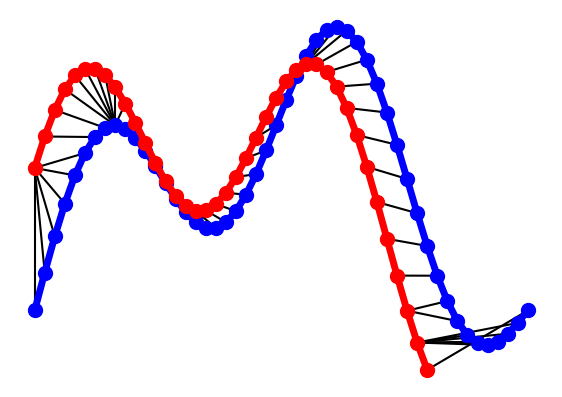

In [ ]:
# Example 2
time1 = np.linspace(start=0, stop=1, num=50)
time2 = time1[0:40]

x1 = 3 * np.sin(np.pi * time1) + 1.5 * np.sin(4*np.pi * time1)
x2 = 3 * np.sin(np.pi * time2 + 0.5) + 1.5 * np.sin(4*np.pi * time2 + 0.5) 

distance, warp_path = fastdtw(x1, x2, dist=euclidean)

fig, ax = plt.subplots(figsize=(7, 5))

# Remove the border and axes ticks
fig.patch.set_visible(False)
ax.axis('off')

for [map_x, map_y] in warp_path:
    ax.plot([map_x, map_y], [x1[map_x], x2[map_y]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)


# Discussion
### pros
-  the DTW distance between the two signals is particularly powerful when the signals have similar patterns. The extrema (maximum and minimum points) between the two signals are correctly mapped. 

### cons
- The issue is around the head and tail of time-series that do not properly match. This is because the DTW algorithm cannot afford the warping invariance for at the endpoints. In short, the effect of this is that a small difference at the sequence endpoints will tend to contribute disproportionately to the estimated similarity.
- Heavy computational burden.


### Reference: 
[1] [An Illustrative Introduction to Dynamic Time Warping](https://towardsdatascience.com/an-illustrative-introduction-to-dynamic-time-warping-36aa98513b98)